In [1]:
import numpy as np
from visualize_grid import visualize_grid
# generate data
m,n = (5,5) # grid size

In [2]:
from ShortestPathGrid import ShortestPathGrid
cost = np.arange((m-1)*n + m*(n-1))
np.random.shuffle(cost)
grid = ShortestPathGrid(m, n, cost=cost)

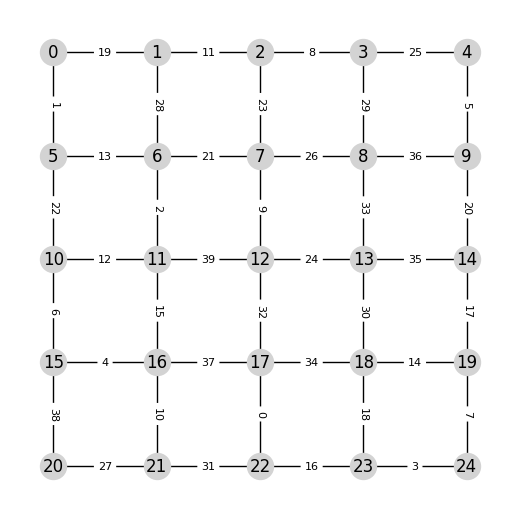

In [3]:
grid.visualize()

In [4]:
# Set source and target of optimization
s = 1 # source node
t = 23 # target node
# Solve the shortest path problem
sol, obj = grid.solve(source=s, target=t)

Optimal objective: 91


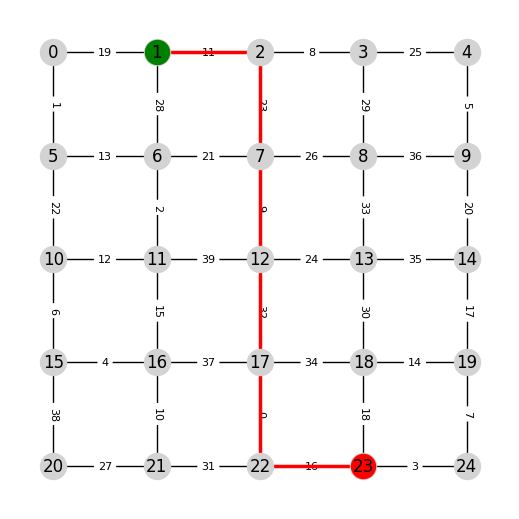

In [5]:
# Visualize the solution
grid.visualize(s = s, t = t, color_edges=sol)
print("Optimal objective:", obj)

In [6]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 1000 # number of test data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(num_train_data+num_test_data, num_feat, (m,n), deg=deg, noise_width=e, seed=135)

In [7]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=num_test_data, random_state=42)

In [ ]:
from LinearRegression import LinearRegression

# Instantiate linear regression model
model = LinearRegression(num_feat=num_feat, num_edges=grid.get_num_edges())

NameError: name 'grid' is not defined

40

# -- Deprecated --

/Users/lucahartmann/Documents/Professional/Research/Prof_Parinaz_Naghizadeh/Code/Shortest_Path_Interdiction/visualize_grid.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


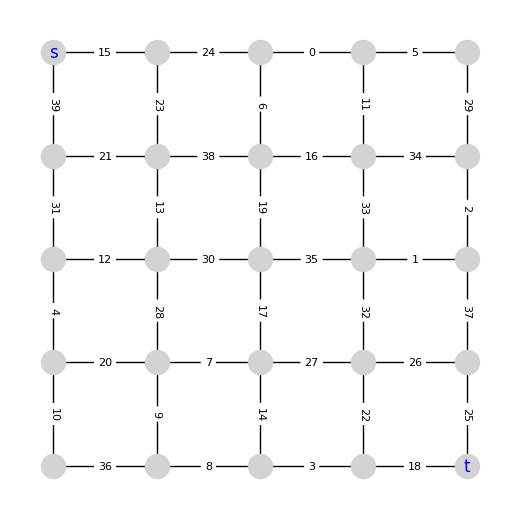

In [2]:
m, n = (5,5)
c = np.arange((m-1)*n + m*(n-1))
np.random.shuffle(c)
s = (0,0)
t = (m-1,n-1)
visualize_grid(m, n, c, s, t)

In [3]:
# build optModel
from pyepo.model.grb import optGrbModel

class shortestPathModel(optGrbModel):

    def __init__(self, m, n):
        self.grid = (m,n)
        self.arcs = self._getArcs()
        super().__init__()

    def _getArcs(self):
        """
        A helper method to get list of arcs for grid network

        Returns:
            list: arcs
        """
        arcs = []
        for i in range(self.grid[0]):
            # edges on rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges in columns
            if i == self.grid[0] - 1:
                continue
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        import gurobipy as gp
        from gurobipy import GRB
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.arcs, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # flow conservation constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                expr = 0
                for e in self.arcs:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x

In [4]:
optmodel = shortestPathModel(m,n)

Restricted license - for non-production use only - expires 2026-11-23


In [5]:
from pyepo.model.grb import shortestPathModel

In [6]:
# solve model
optmodel = shortestPathModel(grid=(m,n)) # init model
optmodel.setObj(c) # set objective function
sol, obj = optmodel.solve() # solve
# print res
print('Obj: {}'.format(obj))
path = {}
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 105.0
(0, 5)
(5, 10)
(10, 11)
(11, 16)
(16, 17)
(17, 18)
(18, 19)
(19, 24)


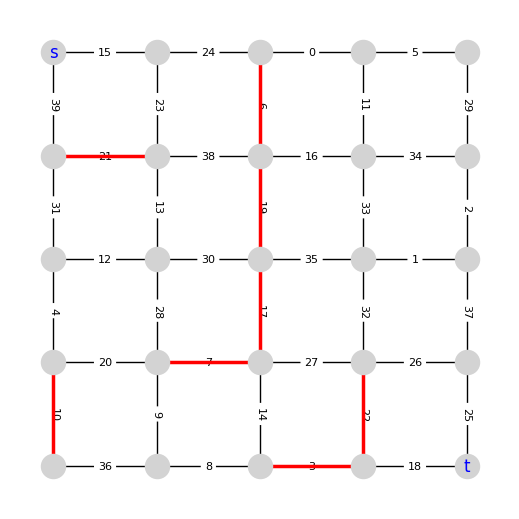

In [7]:
visualize_grid(m, n, c, s, t, path = sol)

In [8]:
### TODO ###
# Use solver to solve shortest path problem and inderdiction problem and visualize them again
# 
# Figure out good software structure
# Preferrably, let different models be different classes. E.g., Grid class, normal graph class? Maybe that's unnecessary bc we'll be using graphs in the end...
# Maybe just make a graph class and a grid class that inherits from it and only changes the way nodes and edges are accessed...
# 